In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from tqdm import tqdm
from IPython import display
import pickle
import os
import random
from F1_Net import F1Net


In [2]:
device = ("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


In [3]:

seed = 7  # You can choose any integer
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Prepare Data

1. Opens the CSV(no encoding)
2. Uses Label Encoder To prepare a dataset with encodings

In [4]:
# Import data and change Position labels to be zero indexed

data = pd.read_csv(open('data/combined_driver_data_cleaned.csv','rb'),delimiter=',')
data["GridPos"] = data["GridPos"].apply(lambda x: x-1)
data["FinishPos"] = data["FinishPos"].apply(lambda x: x-1)

data.head

<bound method NDFrame.head of       Year  Round           Driver          Team   AvgFPTime  QualyTime  \
0     2022      1  Charles Leclerc       Ferrari  110.585000     90.558   
1     2022      1     Carlos Sainz       Ferrari  109.985100     90.687   
2     2022      1   Lewis Hamilton      Mercedes  110.977098     91.048   
3     2022      1   George Russell      Mercedes  107.507673     91.252   
4     2022      1  Kevin Magnussen  Haas F1 Team  111.297087     91.461   
...    ...    ...              ...           ...         ...        ...   
1534  2025      9     Esteban Ocon  Haas F1 Team   96.682667     73.201   
1535  2025      9   Oliver Bearman  Haas F1 Team   97.584178     73.074   
1536  2025      9   Kimi Antonelli      Mercedes   90.285085     72.111   
1537  2025      9  Alexander Albon      Williams   94.480767     72.641   
1538  2024      3   Logan Sargeant      Williams  102.000000     78.000   

      QualTimeDelta  GridPos  FinishPos IsAccurate  
0             0.

In [5]:
#Encode Drivers and Teams

team_encoder = LabelEncoder()
driver_encoder = LabelEncoder()

data["Team_encoded"] = team_encoder.fit_transform(data["Team"])
data["Driver_encoded"] = driver_encoder.fit_transform(data["Driver"])

num_teams = len(team_encoder.classes_)
num_driver = len(driver_encoder.classes_)

data.to_csv("data/Data_with_encoding.csv",index=False)

driver_encoder_path = "encoders/driver_encoder.pkl"
team_encoder_path = "encoders/team_encoder.pkl"

with open(driver_encoder_path,'wb') as f:
    pickle.dump(driver_encoder,f)
print(f"Driver encoder saved to {driver_encoder_path}")

with open(team_encoder_path,'wb') as f:
    pickle.dump(team_encoder,f)
print(f"Driver encoder saved to {team_encoder_path}")

Driver encoder saved to encoders/driver_encoder.pkl
Driver encoder saved to encoders/team_encoder.pkl


# Create Tensors

In [6]:
#Create Tensors for Different seasons and combine them at the end for a unified dataset
#Create Tensors for Train

features = data.keys().drop(["Year","Round","Driver","Team","IsAccurate","FinishPos"])
print(features)

data_2022 = torch.ones(22,20,6)
labels_2022 = torch.zeros(22,20)
for i in range(22):
    new_data = data[(data["Year"] == 2022) & (data["Round"] == i+1)]
    data_2022[i] = torch.tensor(new_data[features].values).float()
    labels_2022[i] = torch.tensor(new_data["FinishPos"].values).float()

data_2023 = torch.ones(22,20,6)
labels_2023 = torch.zeros(22,20)
for i in range(22):
    new_data = data[(data["Year"] == 2023) & (data["Round"] == i+1)]
    data_2023[i] = torch.tensor(new_data[features].values).float()
    labels_2023[i] = torch.tensor(new_data["FinishPos"].values).float()


data_2024 = torch.ones(24,20,6)
labels_2024 = torch.zeros(24,20)
for i in range(24):
    new_data = data[(data["Year"] == 2024) & (data["Round"] == i+1)]
    data_2024[i] = torch.tensor(new_data[features].values).float()
    labels_2024[i] = torch.tensor(new_data["FinishPos"].values).float()

#Update the number of races -> first index to add more races
''''data_2025 = torch.ones(10,20,6)
labels_2025 = torch.zeros(10,20)
for i in range(10):
    new_data = data[(data["Year"] == 2025) & (data["Round"] == i+1)]

    if new_data.shape[0] != 20:
        print(f"Skipping 2025 Round {i+1} due to {new_data.shape[0]} drivers")
        continue
    data_2025[i] = torch.tensor(new_data[features].values).float()
    labels_2025[i] = torch.tensor(new_data["FinishPos"].values).float()'''


data_2025 = []
labels_2025 = []

for i in range(11):  # because there are 11 rounds total
    new_data = data[(data["Year"] == 2025) & (data["Round"] == i+1)]

    if new_data.shape[0] != 20:
        print(f"Skipping 2025 Round {i+1} due to {new_data.shape[0]} drivers")
        continue

    data_2025.append(torch.tensor(new_data[features].values).float())
    labels_2025.append(torch.tensor(new_data["FinishPos"].values).float())

# Then stack after loop
data_2025 = torch.stack(data_2025)
labels_2025 = torch.stack(labels_2025)


print(data_2022.shape,data_2023.shape,data_2024.shape,data_2025.shape)
print(labels_2022.shape,labels_2023.shape,labels_2024.shape,labels_2025.shape)

full_data = torch.cat([data_2022,data_2023,data_2024,data_2025])
full_labels = torch.cat([labels_2022,labels_2023,labels_2024,labels_2025])

full_data = full_data.to(device)
full_labels = full_labels.to(device)
print(full_data.shape)
print(full_labels.shape)


Index(['AvgFPTime', 'QualyTime', 'QualTimeDelta', 'GridPos', 'Team_encoded',
       'Driver_encoded'],
      dtype='object')
Skipping 2025 Round 9 due to 19 drivers
Skipping 2025 Round 10 due to 0 drivers
Skipping 2025 Round 11 due to 0 drivers
torch.Size([22, 20, 6]) torch.Size([22, 20, 6]) torch.Size([24, 20, 6]) torch.Size([8, 20, 6])
torch.Size([22, 20]) torch.Size([22, 20]) torch.Size([24, 20]) torch.Size([8, 20])
torch.Size([76, 20, 6])
torch.Size([76, 20])


In [7]:
# First convert tensors to CPU numpy arrays for sklearn
full_data_np = full_data.cpu().numpy()
full_labels_np = full_labels.cpu().numpy()

# First split: Train and Temp (Val+Test)
train_data_np, temp_data_np, train_labels_np, temp_labels_np = train_test_split(
    full_data_np,
    full_labels_np,
    train_size=0.8,
    stratify=full_labels_np,
    random_state=42
)

# Second split: Val and Test
val_data_np, test_data_np, val_labels_np, test_labels_np = train_test_split(
    temp_data_np,
    temp_labels_np,
    train_size=0.5,
    stratify=temp_labels_np,
    random_state=42
)

# Convert back to tensors
train_data = torch.tensor(train_data_np).to(device)
train_labels = torch.tensor(train_labels_np).to(device)

val_data = torch.tensor(val_data_np).to(device)
val_labels = torch.tensor(val_labels_np).to(device)

test_data = torch.tensor(test_data_np).to(device)
test_labels = torch.tensor(test_labels_np).to(device)

# Print shapes
print(f"Train Data: {list(train_data.shape)} - {list(train_labels.shape)}")
print(f"Val Data: {list(val_data.shape)} - {list(val_labels.shape)}")
print(f"Test Data: {list(test_data.shape)} - {list(test_labels.shape)}")


Train Data: [60, 20, 6] - [60, 20]
Val Data: [8, 20, 6] - [8, 20]
Test Data: [8, 20, 6] - [8, 20]


In [8]:
numerical_feature_indices = [0, 1, 2, 3]
numerical_train_data = train_data[:, :, numerical_feature_indices]

mean_vals = numerical_train_data.mean(dim=(0, 1), keepdim=True) # shape (1,1,num_numerical_features)
std_vals = numerical_train_data.std(dim=(0, 1), keepdim=True)   # shape (1,1,num_numerical_features)
std_vals[std_vals == 0] = 1e-8

print(mean_vals)
print(std_vals)


train_data_tensor_normalized = train_data.clone()
val_data_tensor_normalized = val_data.clone()
test_data_tensor_normalized = test_data.clone()

train_data_tensor_normalized[:, :, numerical_feature_indices] = \
    (train_data_tensor_normalized[:, :, numerical_feature_indices] - mean_vals) / std_vals

val_data_tensor_normalized[:, :, numerical_feature_indices] = \
    (val_data_tensor_normalized[:, :, numerical_feature_indices] - mean_vals) / std_vals

test_data_tensor_normalized[:, :, numerical_feature_indices] = \
    (test_data_tensor_normalized[:, :, numerical_feature_indices] - mean_vals) / std_vals



train_data_tensor_normalized = train_data_tensor_normalized.to(device)
train_labels_tensor = train_labels.to(device) # Labels don't change
val_data_tensor_normalized = val_data_tensor_normalized.to(device)
val_labels_tensor = val_labels.to(device)
test_data_tensor_normalized = test_data_tensor_normalized.to(device)
test_labels_tensor = test_labels.to(device)



print("\nData normalized for numerical features.")

tensor([[[102.9487,  85.8786,   1.6601,   9.3408]]], device='cuda:0')
tensor([[[10.6895, 11.6465,  2.4600,  5.8010]]], device='cuda:0')

Data normalized for numerical features.


In [9]:
save_dir = 'scaling_params'
os.makedirs(save_dir, exist_ok=True)

# Define the paths for saving
mean_vals_path = os.path.join(save_dir, 'mean_vals.pt')
std_vals_path = os.path.join(save_dir, 'std_vals.pt')

# Save the tensors
torch.save(mean_vals, mean_vals_path)
torch.save(std_vals, std_vals_path)

print(f"Mean values saved to: {mean_vals_path}")
print(f"Standard deviation values saved to: {std_vals_path}")

Mean values saved to: scaling_params\mean_vals.pt
Standard deviation values saved to: scaling_params\std_vals.pt


In [10]:
trainDs = TensorDataset(train_data_tensor_normalized,train_labels)
testDs = TensorDataset(test_data_tensor_normalized,test_labels)
valDs = TensorDataset(val_data_tensor_normalized,val_labels)

trainLoader = DataLoader(trainDs,batch_size=32,shuffle=True,drop_last=False)
testLoader = DataLoader(testDs,batch_size=testDs.tensors[0].shape[0])
valLoader = DataLoader(valDs,batch_size = valDs.tensors[0].shape[0])

# Define The Model

In [11]:
#model check

net = F1Net(num_teams,num_driver).to(device)

X,y = next(iter(trainLoader))
print(X.shape)

feat = X[0]


lab = y[0]
print(lab)
print(lab.shape)

rel = 20-lab.float()

print(rel)


team_idx = feat[:,4].long()
driver_idx = feat[:,5].long()
feat = feat[:,:4]


score = net(team_idx,driver_idx,feat)

score_s = score.squeeze()

y_true = rel.unsqueeze(0).cpu().detach().numpy()
y_pred = -score_s.unsqueeze(0).cpu().detach().numpy()

ndcg = ndcg_score(y_true,y_pred,k=20)

print(ndcg)

torch.Size([32, 20, 6])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.], device='cuda:0')
torch.Size([20])
tensor([20., 19., 18., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,
         6.,  5.,  4.,  3.,  2.,  1.], device='cuda:0')
0.8130347109503122


# Training and Testing

In [12]:
#Core training and validation loop without early stopping

net = F1Net(num_teams,num_driver).to(device)
lossfn = nn.KLDivLoss(reduction='batchmean')

optimizer = torch.optim.Adam(net.parameters(),lr=.0001,weight_decay=1e-5)

epochs = 100

trainLosses = []
valNdcg = []



for epoch in tqdm(range(epochs)):
    net.train()
    batchLoss = []
    batchAcc = []
    for X,y in trainLoader:
        for race in range(X.shape[0]):
            features = X[race]
            labels = y[race]

            team_idx = features[:,4].long()
            driver_idx = features[:,5].long()
            features = features[:,:4]

            score = net(team_idx,driver_idx,features)
            score_sm = F.log_softmax(score.squeeze(),dim=0)
            labels_sm = F.softmax(labels.float(),dim=0)

            loss = lossfn(score_sm,labels_sm)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            

    trainLosses.append(np.mean(batchLoss))
   
    
    val_ndcg = []
    
    net.eval()

    with torch.no_grad():
        for X_val,y_val in valLoader:
            for race in range(X_val.shape[0]):

                features = X_val[race]
                labels = y_val[race]
                
                team_idx = features[:,4].long()
                driver_idx = features[:,5].long()
                features = features[:,:4]

                relevance = 20-labels.float()

                score = net(team_idx,driver_idx,features)
                
                score_s = score.squeeze()

                y_true = relevance.unsqueeze(0).cpu().detach().numpy()
                y_pred = -score_s.unsqueeze(0).cpu().detach().numpy()

                ndcg = ndcg_score(y_true,y_pred,k=20)

                val_ndcg.append(ndcg)
                
    valNdcg.append(np.mean(val_ndcg))
   



    

            

    

100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


In [13]:
# #Core training and validation loop with early stopping

# net = F1Net(num_teams,num_driver).to(device)
# model_best = F1Net(num_teams,num_driver).to(device)

# lossfn = nn.KLDivLoss(reduction='batchmean')
# optimizer = torch.optim.Adam(net.parameters(),lr=.0001,weight_decay=1e-5)

# epochs = 100
# trainLosses = []
# valLoss = []

# patience = 15
# p_count = 0
# best_epoch = -1
# best_val_loss = float('inf')




# for epoch in tqdm(range(epochs)):
#     net.train()
#     batchLoss = []
#     batchAcc = []
#     for X,y in trainLoader:
#         for race in range(X.shape[0]):
#             features = X[race]
#             labels = y[race]

#             team_idx = features[:,4].long()
#             driver_idx = features[:,5].long()
#             features = features[:,:4]

#             score = net(team_idx,driver_idx,features)
#             score_sm = F.log_softmax(score.squeeze(),dim=0)
#             labels_sm = F.softmax(labels.float(),dim=0)

#             loss = lossfn(score_sm,labels_sm)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             batchLoss.append(loss.item())
            

#     current_train_loss = (np.mean(batchLoss))
#     trainLosses.append(current_train_loss)
   
    
#     val_batchLoss = []
#     net.eval()

#     with torch.no_grad():
#         for X_val,y_val in valLoader:
#             for race in range(X_val.shape[0]):

#                 features = X_val[race]
#                 labels = y_val[race]
                
#                 team_idx = features[:,4].long()
#                 driver_idx = features[:,5].long()
#                 features = features[:,:4]

#                 score = net(team_idx,driver_idx,features)
#                 score_sm = F.log_softmax(score.squeeze(),dim=0)
#                 labels_sm = F.softmax(labels,dim=0)

#                 loss = lossfn(score_sm,labels_sm)

#                 val_batchLoss.append(loss.item())
                
#     current_val_loss = np.mean(val_batchLoss)
#     valLoss.append(current_val_loss)

#     print(f"Epoch {epoch+1}/{epochs} - Train Loss: {current_train_loss:.6f} - Val Loss: {current_val_loss:.6f}")

#     if(current_val_loss<best_val_loss):
#         best_val_loss = current_val_loss
#         p_count = 0

#         model_best.load_state_dict(net.state_dict())
#         best_epoch = epoch+1

#         print(f"Validation loss improved to {best_val_loss:.6f}. Updating model_best object from Epoch {best_epoch}.")

   



    

            

    

In [14]:
# Save the trained Model
savePath = 'saved_models/f1_ranking_model_6_7_2025.pth'
#savePath2 = 'f1_ranking_model_best.pth'

checkpoint = {
    "model_state_dict" : net.state_dict(),
}

torch.save(net.state_dict(),savePath)
print("Model Saved")
#torch.save(model_best.state_dict(),savePath2)
#print("Model Saved")



Model Saved


Text(0.5, 1.0, 'Val NDCG: 0.9296155221374469')

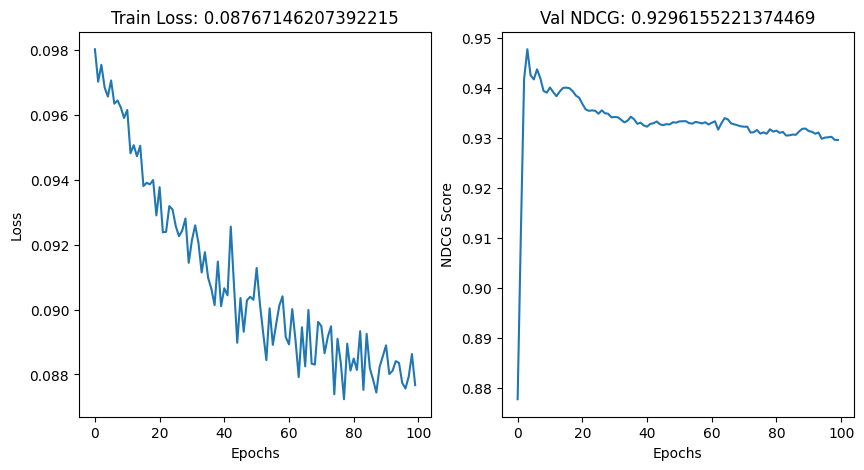

In [15]:
#Plot train and validation loss

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(trainLosses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title(f"Train Loss: {trainLosses[-1]}")

ax[1].plot(valNdcg)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("NDCG Score")
ax[1].set_title(f"Val NDCG: {valNdcg[-1]}")

In [16]:
net.to(device)
net.eval()

test_ndcg = []
with torch.no_grad():
    for X_val,y_val in testLoader:
        for race in range(X_val.shape[0]):

            features = X_val[race]
            labels = y_val[race]
            
            team_idx = features[:,4].long()
            driver_idx = features[:,5].long()
            features = features[:,:4]

            relevance = 20-labels.float()

            score = net(team_idx,driver_idx,features)
            
            score_s = score.squeeze()

            y_true = relevance.unsqueeze(0).cpu().detach().numpy()
            y_pred = -score_s.unsqueeze(0).cpu().detach().numpy()

            ndcg = ndcg_score(y_true,y_pred,k=20)

            test_ndcg.append(ndcg)

Text(0.5, 1.0, 'Test NDCG: 0.9611848964585215')

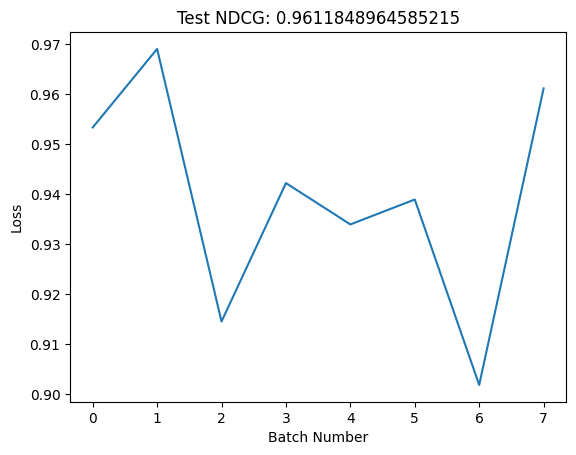

In [17]:
#Plot Test Loss
plt.plot(test_ndcg)
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title(f"Test NDCG: {test_ndcg[-1]}")

In [18]:
#Test on a single race
net = net.to(device)
X_test,y_test = next(iter(testLoader))

feat = X_test[0]
labels = y_test[0] 

driver_idx = feat[:,5].long()
team_idx = feat[:,4].long()
feat_numerical = feat[:,:4]

original_drivers_order = []

for i in driver_idx:
    arr = driver_encoder.inverse_transform([i.item()])
    original_drivers_order.append(arr[0])


preds = net(team_idx,driver_idx,feat_numerical)
preds = preds.squeeze()

predicted_ranking_data = []
for i in range(len(original_drivers_order)):
    predicted_ranking_data.append({
        'Name': original_drivers_order[i],
        'predicted_score': preds[i].item(),
        'true-rank':labels[i].item()

    })

predicted_ranking_data.sort(key = lambda x: x['predicted_score'])

true_ranking_data = []
for i in range(len(original_drivers_order)):
    true_ranking_data.append({
        'driver_name': original_drivers_order[i],
        'true_rank': labels[i].item()
    })

true_ranking_data.sort(key = lambda x: x['true_rank'])


print("\n--- Predicted vs. Actual Ranking ---")
print("{:<10} {:<25} {:<25}".format("Rank", "Predicted Driver", "Actual Driver"))
print("-" * 60)


for i in range(len(predicted_ranking_data)):
    predicted_driver_at_this_rank = predicted_ranking_data[i]['Name']
    actual_driver_at_this_rank = true_ranking_data[i]['driver_name'] # Get driver from the true sorted list

    print(f"{i+1:<10} {predicted_driver_at_this_rank:<25} {actual_driver_at_this_rank:<25}")



--- Predicted vs. Actual Ranking ---
Rank       Predicted Driver          Actual Driver            
------------------------------------------------------------
1          George Russell            Oscar Piastri            
2          Max Verstappen            George Russell           
3          Oscar Piastri             Lando Norris             
4          Lando Norris              Charles Leclerc          
5          Jack Doohan               Lewis Hamilton           
6          Kimi Antonelli            Max Verstappen           
7          Lewis Hamilton            Pierre Gasly             
8          Fernando Alonso           Esteban Ocon             
9          Pierre Gasly              Yuki Tsunoda             
10         Yuki Tsunoda              Oliver Bearman           
11         Carlos Sainz              Kimi Antonelli           
12         Esteban Ocon              Alexander Albon          
13         Lance Stroll              Isack Hadjar             
14         Nico Hul

In [19]:
#Test on a single race
net = net.to(device)
X_test,y_test = next(iter(testLoader))

feat = X_test[1]
labels = y_test[1] 

driver_idx = feat[:,5].long()
team_idx = feat[:,4].long()
feat_numerical = feat[:,:4]

original_drivers_order = []

for i in driver_idx:
    arr = driver_encoder.inverse_transform([i.item()])
    original_drivers_order.append(arr[0])


preds = net(team_idx,driver_idx,feat_numerical)
preds = preds.squeeze()

predicted_ranking_data = []
for i in range(len(original_drivers_order)):
    predicted_ranking_data.append({
        'Name': original_drivers_order[i],
        'predicted_score': preds[i].item(),
        'true-rank':labels[i].item()

    })

predicted_ranking_data.sort(key = lambda x: x['predicted_score'])

true_ranking_data = []
for i in range(len(original_drivers_order)):
    true_ranking_data.append({
        'driver_name': original_drivers_order[i],
        'true_rank': labels[i].item()
    })

true_ranking_data.sort(key = lambda x: x['true_rank'])


print("\n--- Predicted vs. Actual Ranking ---")
print("{:<10} {:<25} {:<25}".format("Rank", "Predicted Driver", "Actual Driver"))
print("-" * 60)


for i in range(len(predicted_ranking_data)):
    predicted_driver_at_this_rank = predicted_ranking_data[i]['Name']
    actual_driver_at_this_rank = true_ranking_data[i]['driver_name'] # Get driver from the true sorted list

    print(f"{i+1:<10} {predicted_driver_at_this_rank:<25} {actual_driver_at_this_rank:<25}")



--- Predicted vs. Actual Ranking ---
Rank       Predicted Driver          Actual Driver            
------------------------------------------------------------
1          George Russell            Max Verstappen           
2          Max Verstappen            Lando Norris             
3          Daniel Ricciardo          George Russell           
4          Oscar Piastri             Lewis Hamilton           
5          Lando Norris              Oscar Piastri            
6          Lance Stroll              Fernando Alonso          
7          Lewis Hamilton            Lance Stroll             
8          Fernando Alonso           Daniel Ricciardo         
9          Yuki Tsunoda              Pierre Gasly             
10         Valtteri Bottas           Esteban Ocon             
11         Alexander Albon           Nico Hulkenberg          
12         Esteban Ocon              Kevin Magnussen          
13         Sergio Perez              Valtteri Bottas          
14         Carlos S